# Inputs
---

In [1]:
import numpy as np, zarr, nrrd
# alignment functions
from bigstream.align import alignment_pipeline
from bigstream.transform import apply_transform
import tifffile

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
p = '/u/home/f/f7xiesnm/project-zipursky/easifish/lt186/outputs/'
outdir = '/u/home/f/f7xiesnm/project-zipursky/easifish/results/test_bigstream_lt186_cap_v2'
!mkdir -p $outdir

In [3]:
r1_path = p + '/r1/stitching/export.n5'
r2_path = p + '/r2/stitching/export.n5'
r6_path = p + '/r6/stitching/export.n5'
r7_path = p + '/r7/stitching/export.n5'

r1_zarr = zarr.open(store=zarr.N5Store(r1_path), mode='r')
r2_zarr = zarr.open(store=zarr.N5Store(r2_path), mode='r')
r6_zarr = zarr.open(store=zarr.N5Store(r6_path), mode='r')
r7_zarr = zarr.open(store=zarr.N5Store(r7_path), mode='r')

r1 = r1_zarr['/c3/s4'][...]
r2 = r2_zarr['/c3/s4'][...]
r6 = r6_zarr['/c3/s4'][...]
r7 = r7_zarr['/c3/s4'][...]


In [4]:
np.max(r1), np.max(r2), np.max(r6), np.max(r7)

(61957, 47284, 63646, 56672)

In [5]:
th = np.percentile(r1, 99.9)
r1[r1>th] = th

th = np.percentile(r2, 99.9)
r2[r2>th] = th

th = np.percentile(r6, 99.9)
r6[r6>th] = th

th = np.percentile(r7, 99.9)
r7[r7>th] = th

In [6]:
np.max(r1), np.max(r2), np.max(r6), np.max(r7)

(167, 239, 192, 178)

In [7]:
# tifffile.imwrite(outdir+'/r1.tiff', r1)
# tifffile.imwrite(outdir+'/r2.tiff', r2)
# tifffile.imwrite(outdir+'/r6.tiff', r6)
# tifffile.imwrite(outdir+'/r7.tiff', r7)

In [8]:
mov_path = r7_path
fix_path = r1_path

mov = r7
fix = r1

output_mat = outdir+'/affine_r7tor1.mat'
output_tif = outdir+'/affine_r7tor1.tiff'

In [9]:

exp_factor = 2  # replace this with the known expansion factor for your sample to use pre-expansion units

s1_scale = [1,2,2] # z,y,x
s3_scale = [4,8,8]
s4_scale = [9,16,16]

# load fix data and spacing
fix_zarr = zarr.open(store=zarr.N5Store(fix_path), mode='r')
fix_meta = fix_zarr.attrs.asdict()
fix_spacing = np.array(fix_meta['pixelResolution']['dimensions'][::-1]) / exp_factor
fix_spacing_s1 = fix_spacing * s1_scale 
fix_spacing_s3 = fix_spacing * s3_scale 
fix_spacing_s4 = fix_spacing * s4_scale 

# load mov data and spacing
mov_zarr = zarr.open(store=zarr.N5Store(mov_path), mode='r')
mov_meta = mov_zarr.attrs.asdict()
mov_spacing = np.array(mov_meta['pixelResolution']['dimensions'][::-1]) / exp_factor
mov_spacing_s1 = mov_spacing * s1_scale
mov_spacing_s3 = mov_spacing * s3_scale 
mov_spacing_s4 = mov_spacing * s4_scale 

# print spacings
print(fix_spacing, mov_spacing)
print(fix_spacing_s1, mov_spacing_s1)
print(fix_spacing_s3, mov_spacing_s3)
print(fix_spacing_s4, mov_spacing_s4)

# print shapes
print(fix_zarr['/c3/s0'].shape, mov_zarr['/c3/s0'].shape)
print(fix_zarr['/c3/s3'].shape, mov_zarr['/c3/s3'].shape)
print(fix_zarr['/c3/s4'].shape, mov_zarr['/c3/s4'].shape)

[0.21  0.115 0.115] [0.21  0.115 0.115]
[0.21 0.23 0.23] [0.21 0.23 0.23]
[0.84 0.92 0.92] [0.84 0.92 0.92]
[1.89 1.84 1.84] [1.89 1.84 1.84]
(2593, 7309, 9049) (2296, 7336, 9091)
(648, 913, 1131) (574, 917, 1136)
(288, 456, 565) (255, 458, 568)


# Alignment
---

### global

In [10]:
# alignment functions
from bigstream.align import alignment_pipeline
from bigstream.transform import apply_transform

In [11]:
# define alignment steps
ransac_kwargs = {
    'blob_sizes':[2, 8],
    'cc_radius':12,
    'match_threshold':0.4,
    'nspots':10000,
}

affine_kwargs = {
    'alignment_spacing':4.0,
    'shrink_factors':(1,),
    'smooth_sigmas':(4.,),
    'optimizer_args':{
        'learningRate':0.25,
        'minStep':0.,
        'numberOfIterations':400,
    },
    'metric':'C',
}


steps = [
    # ('ransac', ransac_kwargs,),
    ('affine', affine_kwargs,),
]

In [12]:
%%time


# align
affine = alignment_pipeline(
    fix, mov,
    fix_spacing_s4,
    mov_spacing_s4,
    steps,
    # fix_mask=fix_mask,
    # mov_mask=mov_mask,
)

# apply affine only
affine_aligned = apply_transform(
    fix, mov,
    fix_spacing_s4, mov_spacing_s4,
    transform_list=[affine,],
)

# write results
np.savetxt(output_mat, affine)
tifffile.imwrite(output_tif, affine_aligned)

LEVEL:  0  ITERATION:  0  METRIC:  -0.2491053401020854
LEVEL:  0  ITERATION:  1  METRIC:  -0.25352558216565696
LEVEL:  0  ITERATION:  2  METRIC:  -0.2575460145721325
LEVEL:  0  ITERATION:  3  METRIC:  -0.261156591423668
LEVEL:  0  ITERATION:  4  METRIC:  -0.26434859859072973
LEVEL:  0  ITERATION:  5  METRIC:  -0.26745986693840335
LEVEL:  0  ITERATION:  6  METRIC:  -0.27081416928254176
LEVEL:  0  ITERATION:  7  METRIC:  -0.2709864613493191
LEVEL:  0  ITERATION:  8  METRIC:  -0.2707569560773271
LEVEL:  0  ITERATION:  9  METRIC:  -0.27088914658289037
LEVEL:  0  ITERATION:  10  METRIC:  -0.27108094706552194
LEVEL:  0  ITERATION:  11  METRIC:  -0.27118928510826895
LEVEL:  0  ITERATION:  12  METRIC:  -0.2714986740988649
LEVEL:  0  ITERATION:  13  METRIC:  -0.2725320232981632
LEVEL:  0  ITERATION:  14  METRIC:  -0.27441257737031904
LEVEL:  0  ITERATION:  15  METRIC:  -0.27717375093566726
LEVEL:  0  ITERATION:  16  METRIC:  -0.2804482476010748
LEVEL:  0  ITERATION:  17  METRIC:  -0.28357735332

In [13]:
affine[:3,3]

array([-55.05909622, -47.90113614,  31.65684533])

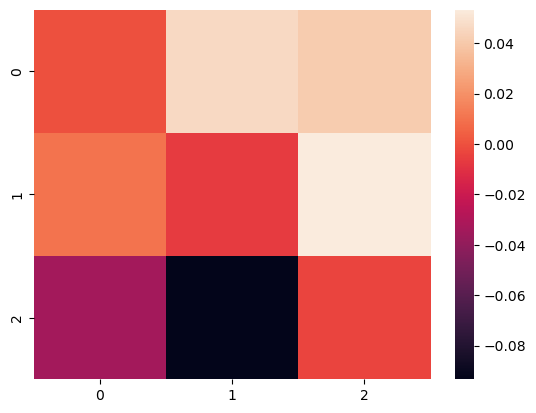

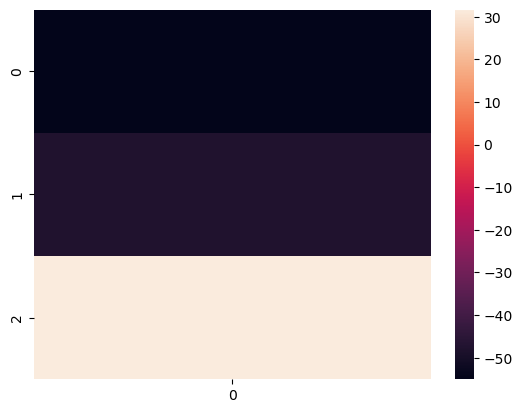

In [14]:
sns.heatmap(affine[:3,:3] - np.eye(3))
plt.show()
sns.heatmap(affine[:3, 3].reshape(-1,1))
plt.show()